### FastAI Transfer Learning on Stanford Cars Dataset with 1Cycle Learning Rate Policy

In [1]:
import os
import shutil

In [2]:
%%capture
import random
import numpy as np
import pandas as pd
import numpy.random as rng
import matplotlib.pyplot as plt

In [3]:
import imageio

This part is taking the data which has already been organized from Sylvain's code:

In [4]:
if os.path.exists('./Adam-experiments'):
    os.chdir('./Adam-experiments')
if os.path.exists('./data/cars'):
    os.chdir('./data/cars/')

In [5]:
!ls

annots.csv  car_ims  car_ims.tgz  cars_annos.mat  models  tmp  train  valid


In [6]:
import scipy.io
annos = scipy.io.loadmat('cars_annos.mat')

In [7]:
annos.keys()

dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [8]:
classes = pd.DataFrame(annos['class_names'])

In [9]:
classes.get(0).values[0][0]

'AM General Hummer SUV 2000'

In [10]:
annotations = np.array(annos['annotations'])

In [11]:
len(annotations[0])

16185

In [12]:
# Rubric: annotations[0] is the matrix of data
# [0][i] is the ith row of the matrix
# [0][i][j] is the (i,j)th element of the matrix
# j = 0 is fname, 1 is bboxx1, 2 is bboxy1, 
# 3 is bboxx2, 4 is bboxy2, 5 is class, 6 is bool(test)
# to get the fname, append [0]
# to get all others, append [0][0]

In [13]:
from collections import defaultdict

#classes are minus 1 to convert MATLAB indexing

train_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 0]
train_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 0]

test_fnames = [annotations[0][i][0][0] for i in range(len(annotations[0]))
                if annotations[0][i][6][0][0] == 1]
test_classes = [annotations[0][ii][5][0][0] - 1 for ii in range(len(annotations[0]))
                if annotations[0][ii][6][0][0] == 1]

train_data = zip(train_classes, train_fnames)
test_data = zip(test_classes, test_fnames)

train_dict = defaultdict(list)
test_dict = defaultdict(list)

for tr_cl, tr_fname in train_data:
    train_dict[tr_cl].append(tr_fname)
    
for ts_cl, ts_fname in test_data:
    test_dict[ts_cl].append(ts_fname)


['car_ims/001380.jpg', 'car_ims/001381.jpg', 'car_ims/001382.jpg', 'car_ims/001383.jpg']


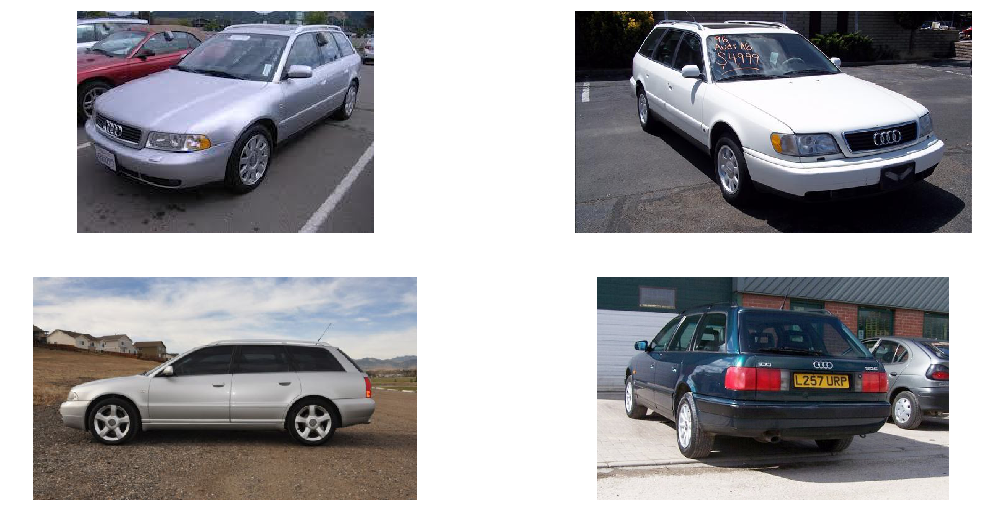

Audi 100 Wagon 1994


In [14]:
# Look at several images from the training set
rand_cl = rng.choice(196)
print(train_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(train_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show() 

print(classes.get(rand_cl).values[0][0])

['car_ims/001423.jpg', 'car_ims/001424.jpg', 'car_ims/001425.jpg', 'car_ims/001426.jpg']


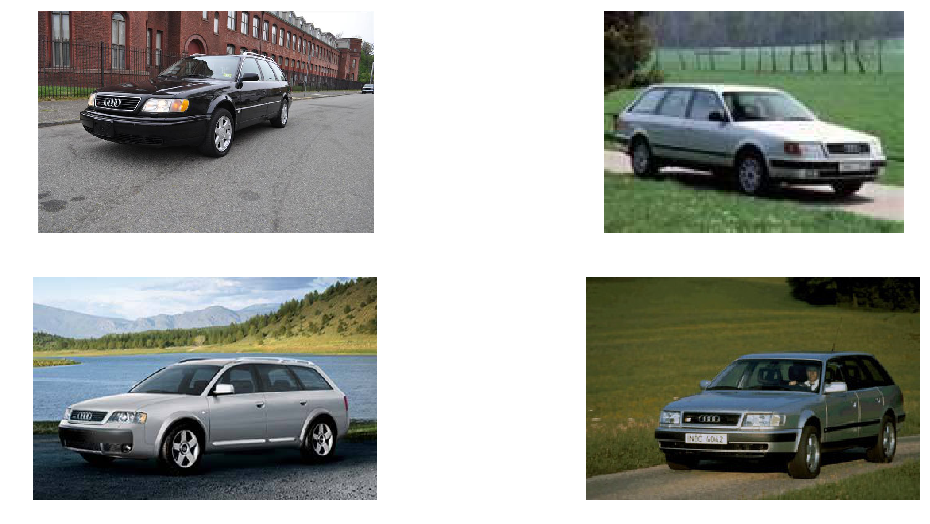

Audi 100 Wagon 1994


In [15]:
# Look at several images from the testing set
print(test_dict[rand_cl][0:4])

fig=plt.figure(figsize=(18, 9))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = imageio.imread(test_dict[rand_cl][i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
plt.show()

print(classes.get(rand_cl).values[0][0])

In [16]:
# Make train and validation folders for fastai dataloader

if os.path.exists('./train'):
    shutil.rmtree('./train')
if os.path.exists('./valid'):
    shutil.rmtree('./valid')
    
!mkdir ./train
!mkdir ./valid

# Populate the class folders with images
for cl in train_dict.keys():
    train_folder = './train/' + str(cl) + "/"
    valid_folder = './valid/' + str(cl) + "/"
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
    if not os.path.exists(valid_folder):
        os.mkdir(valid_folder)
        
    for tr_img in train_dict[cl]:
        shutil.copy(tr_img, train_folder)
    for val_img in test_dict[cl]:
        shutil.copy(val_img, valid_folder)       

In [17]:
%%capture

%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
#import skimage

In [18]:
def get_data(sz, bs=128, arch=resnet50, aug_tfms=transforms_side_on,
             max_zoom=1.05, num_workers=8):
    tfms = tfms_from_model(arch, sz, 
                       aug_tfms=aug_tfms, 
                       max_zoom=max_zoom)
    data = ImageClassifierData.from_paths('', bs=bs, tfms=tfms,
                                          num_workers=num_workers)
    return data

arch = resnet50
sz = 224
# Side on tranforms but increased a bit
aug_tfms = [RandomRotateZoom(deg=30, zoom=1.25, stretch=0.1)]
aug_tfms += [RandomLighting(0.05, 0.05)]
aug_tfms += [RandomFlip()]
#aug_tfms += [GoogleNetResize(targ_sz=sz)]
data = get_data(sz, bs=128, aug_tfms=aug_tfms, max_zoom=1)

In [19]:
# Without precompute set to False, this gives bad results.
learn = ConvLearner.pretrained(arch, data, ps=[0.5,0.5], precompute=False)

Here I modified the default FastAI pipeline by enhancing the augmentations and increasing the dropout on the penultimate layer. Although I haven't extensively tested yet, the augmentations didn't seem to have much effect on overfitting compared to the dropout.

Precomputation seems to just make it much harder to train the entire network afterward, so any time saved on precomputation is not worth it.

In [20]:
learn.opt_fn = optim.Adam

In [21]:
learn.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [22]:
learn.freeze()

In [23]:
#lrf=learn.lr_find(wds = 1e-2, use_wd_sched=True, start_lr=1e-05, end_lr=10)

In [24]:
#learn.sched.plot(n_skip=0,n_skip_end=3)

This code will barely fit in a 16 GB P100 GPU. So I use empty_cache() in order to maximize the memory utilization.

In addition, running the learning rate finder takes up memory space so when testing a full model it is probably best to run the finders and then run the model all at once separately. 

In [25]:
#Use this to free more GPU memory after running training
torch.cuda.empty_cache()

In [26]:
result, ep_vals = learn.fit(3e-2, 1, cycle_len=10, use_clr_beta=(10, 10), wds=1e-2, use_wd_sched=True, get_ep_vals=True)

epoch      trn_loss   val_loss   accuracy                  
    0      4.153422   3.009878   0.263027  
    1      3.57885    2.785779   0.299838                  
    2      3.255453   2.488543   0.369357                  
    3      3.091446   2.532665   0.347096                  
    4      3.082599   2.455515   0.362766                  
    5      2.905837   2.211865   0.419351                  
    6      2.612229   2.040636   0.461012                  
    7      2.352399   1.901461   0.499192                  
    8      2.102412   1.804346   0.52394                   
    9      1.917331   1.766491   0.530034                  



I trained the head only until the training loss was about equal to the validation loss in order to avoid too much overfitting.

In [27]:
learn.unfreeze()
torch.cuda.empty_cache()

In [28]:
#lrf=learn.lr_find(wds = 3e-2, use_wd_sched=True, start_lr=1e-06, end_lr=10)
#learn.sched.plot(n_skip=0,n_skip_end=3)

In [29]:
torch.cuda.empty_cache()

In [30]:
lr2=1e-2

In [31]:
# This particular dataset seems to train better with
# somewhat higher learning rates in the lower layers,
# possibly because the Imagenet weights don't generalize
# to this dataset very well.
lrs = np.array([lr2/30,lr2/3,lr2])

In [32]:
result2, ep_vals2 = learn.fit(lrs, 1, cycle_len=20, use_clr_beta=(10, 10), wds=1e-1, use_wd_sched=True)

epoch      trn_loss   val_loss   accuracy                  
    0      2.241384   1.781512   0.514861  
    1      1.871742   1.771533   0.522199                  
    2      1.713187   1.766449   0.518468                  
    3      1.587356   1.376167   0.609999                  
    4      1.502316   1.508992   0.580276                  
    5      1.43117    1.283223   0.632011                  
    6      1.383424   1.577235   0.576296                  
    7      1.312273   1.438445   0.608382                  
    8      1.295496   1.553304   0.588857                  
    9      1.211503   1.129037   0.685736                  
    10     1.030744   0.825422   0.766944                  
    11     0.870749   0.86356    0.753513                  
    12     0.71392    0.721779   0.795299                  
    13     0.603614   0.623733   0.821042                  
    14     0.484758   0.597952   0.821788                  
    15     0.393      0.510326   0.854496               

In [33]:
torch.cuda.empty_cache()

This model still overfits a significant amount. More regularization should be added, perhaps by increasing dropout on the 2nd layer or even more weight decay. In addition, it appears that the learning rate could possibly go even higher because the training gets stuck around epochs 2-5. Perhaps a higher learning rate could coax it to "jump out" of the poor performing section earlier.

In [34]:
log_preds, y = learn.TTA()

In [35]:
probs = np.exp(log_preds)

In [36]:
avg_TTA = np.mean(probs, axis = 0)

In [37]:
preds = np.argmax(avg_TTA,axis=1)
targs = y

In [38]:
TTA_acc = (preds==targs).mean()
print(TTA_acc)

0.8939186668324836


TTA improved the accuracy very slightly, from  87.7% to 88.8%.

(array([45., 29., 41., 43., 42., 39., 39., 44., 39., 45., 44., 42., 47., 32., 43., 35., 43., 43., 45., 37.,
        39., 40., 71., 38., 51., 45., 38., 46., 40., 44., 44., 39., 39., 41., 41., 34., 40., 47., 42., 32.,
        46., 21., 48., 40., 45., 32., 41., 34., 32., 42., 53., 44., 46., 41., 48., 43., 39., 38., 46., 30.,
        50., 43., 39., 40., 37., 30., 37., 54., 50., 47., 43., 35., 47., 43., 48., 44., 42., 36., 48., 34.,
        49., 42., 37., 37., 31., 36., 42., 42., 49., 42., 48., 36., 44., 45., 36., 43., 36., 51., 38., 41.,
        37., 50., 49., 43., 40., 45., 41., 37., 51., 46., 36., 35., 49., 33., 35., 33., 42., 39., 38., 43.,
        36., 43., 35., 46., 45., 50., 41., 40., 33., 43., 32., 31., 27., 49., 49., 31., 41., 36., 38., 38.,
        42., 47., 45., 41., 48., 31., 48., 41., 41., 46., 39., 36., 36., 40., 28., 45., 36., 53., 38., 40.,
        40., 29., 48., 47., 28., 46., 38., 41., 59., 45., 38., 39., 49., 43., 37., 47., 47., 36., 53., 46.,
        41., 46., 35., 39., 

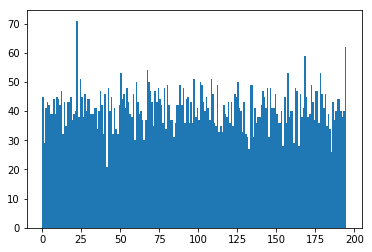

In [39]:
plt.hist(preds, bins=np.arange(196))

We can see from the histogram that class 22 is especially overpredicted, as well as class 195 to a lesser extent. To see which car this is, print the class label:

In [40]:
print(classes.get(22).values[0][0])

Audi S4 Sedan 2012


The worst predicted class is found by taking the mode of the targets that were missed:

In [41]:
from scipy.stats import mode
mode(y[np.where(preds != targs)])

ModeResult(mode=array([164]), count=array([23]))

In [42]:
print(classes.get(35).values[0][0])

BMW M6 Convertible 2010


In [43]:
test_dict[35]

['car_ims/002911.jpg',
 'car_ims/002912.jpg',
 'car_ims/002913.jpg',
 'car_ims/002914.jpg',
 'car_ims/002915.jpg',
 'car_ims/002916.jpg',
 'car_ims/002917.jpg',
 'car_ims/002918.jpg',
 'car_ims/002919.jpg',
 'car_ims/002920.jpg',
 'car_ims/002921.jpg',
 'car_ims/002922.jpg',
 'car_ims/002923.jpg',
 'car_ims/002924.jpg',
 'car_ims/002925.jpg',
 'car_ims/002926.jpg',
 'car_ims/002927.jpg',
 'car_ims/002928.jpg',
 'car_ims/002929.jpg',
 'car_ims/002930.jpg',
 'car_ims/002931.jpg',
 'car_ims/002932.jpg',
 'car_ims/002933.jpg',
 'car_ims/002934.jpg',
 'car_ims/002935.jpg',
 'car_ims/002936.jpg',
 'car_ims/002937.jpg',
 'car_ims/002938.jpg',
 'car_ims/002939.jpg',
 'car_ims/002940.jpg',
 'car_ims/002941.jpg',
 'car_ims/002942.jpg',
 'car_ims/002943.jpg',
 'car_ims/002944.jpg',
 'car_ims/002945.jpg',
 'car_ims/002946.jpg',
 'car_ims/002947.jpg',
 'car_ims/002948.jpg',
 'car_ims/002949.jpg',
 'car_ims/002950.jpg',
 'car_ims/002951.jpg']

In [44]:
wrongs = np.where(preds != targs)

In [45]:
cl_bins = np.cumsum(list(map(len, test_dict.values()))) + 1
cl_bins.insert(0, x)

In [46]:
#number wrong in each class
np.histogram(wrongs,bins=cl_bins)[0]

array([ 8,  4,  2,  1,  7,  5,  1,  5,  2,  1,  3,  0,  2,  5, 11,  3,  5,  2,  3,  3,  2,  5,  8,  9,  3,
        2,  0,  4,  3,  4,  2,  2,  3,  5,  1, 14,  5,  0,  2,  2,  4,  3,  2,  1,  2,  8,  4,  3,  2,  0,
        1,  3,  1,  4,  4,  3,  2, 10,  4,  9,  3,  3,  1,  2,  1,  2,  1,  2,  8,  2,  1,  4,  2,  2,  4,
        6,  0,  3,  1, 10,  7,  2,  6,  6,  5,  6,  7,  1,  2,  9, 12,  6,  6,  2, 10,  2,  5,  0,  4,  3,
        4,  5,  0,  0,  3,  0,  1,  5,  2,  4, 10, 10,  9,  8,  5,  3,  1, 10,  2,  5,  9,  6,  2,  1,  5,
        1,  2,  3,  2,  8,  9, 14,  8,  5,  6,  6,  2,  4,  3,  1,  2,  2,  0,  1,  5, 12,  4,  6,  1,  5,
        3,  4,  6,  6, 10,  6,  9,  6,  5,  4, 10,  8,  4, 21,  9, 10,  9, 11,  5,  3,  3,  1,  3,  4,  6,
        1,  4, 10,  2,  1,  5,  5,  8,  4, 10,  8,  3,  2,  0,  4,  4,  4,  2,  5])

In [47]:
cl_bins = [0] + cl_bins

In [48]:
idx_in_cl = wrongs[50] - cl_bins[50]

IndexError: tuple index out of range

In [ ]:
cl = targs[wrongs[50]]

In [ ]:
test_dict[cl][idx_in_cl]